In [5]:
from typing import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt


class ReviewState(TypedDict):
    generated_text: str


def review_node(state: ReviewState):
    # Ask a reviewer to edit the generated content
    updated = interrupt({
        "instruction": "Review and edit this content",
        "content": state["generated_text"],
    })
    return {"generated_text": updated}


builder = StateGraph(ReviewState)
builder.add_node("review", review_node)
builder.add_edge(START, "review")
builder.add_edge("review", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

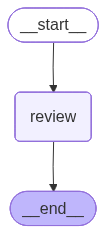

In [6]:
from IPython.display import Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:

config = {"configurable": {"thread_id": "review-42"}}
initial = graph.invoke({"generated_text": "Initial draft"}, config=config)
print(initial["__interrupt__"])  # -> [Interrupt(value={'instruction': ..., 'content': ...})]

# Resume with the edited text from the reviewer
final_state = graph.invoke(
    Command(resume="Improved draft after review"),
    config=config,
)
print(final_state["generated_text"])  # -> "Improved draft after review"

[Interrupt(value={'instruction': 'Review and edit this content', 'content': 'Initial draft'}, id='b4e42433bcc8046b4b9795abaeb052d4')]
Improved draft after review
